<center><img src="https://raw.githubusercontent.com/openvinotoolkit/anomalib/main/docs/source/images/logos/anomalib-wide-blue.png" alt="Paris" class="center"></center>

<center>💙 A library for benchmarking, developing and deploying deep learning anomaly detection algorithms</center>

______________________________________________________________________

> NOTE:
> This notebook is originally created by @innat on [Kaggle](https://www.kaggle.com/code/ipythonx/mvtec-ad-anomaly-detection-with-anomalib-library/notebook).

[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

The library supports [`MVTec AD`](https://www.mvtec.com/company/research/datasets/mvtec-ad) (CC BY-NC-SA 4.0) and [`BeanTech`](https://paperswithcode.com/dataset/btad) (CC-BY-SA) for **benchmarking** and `folder` for custom dataset **training/inference**. In this notebook, we will explore `anomalib` training a PADIM model on the `MVTec AD` bottle dataset and evaluating the model's performance. The sections in this notebook explores the steps in `tools/train.py` more in detail. Those who would like to reproduce the results via CLI could use `python tools/train.py --model padim`.

## Installing Anomalib

Installation can be done in two ways: (i) install via PyPI, or (ii) installing from sourc, both of which are shown below:

### I. Install via PyPI

In [1]:
# Option - I: Uncomment the next line if you want to install via pip.
# %pip install anomalib

### II. Install from Source
This option would initially download anomalib repository from github and manually install `anomalib` from source, which is shown below:

In [2]:
# Option - II: Uncomment the next three lines if you want to install from the source.
# !git clone https://github.com/openvinotoolkit/anomalib.git
# %cd anomalib
# %pip install .

 Now let's verify the working directory. This is to access the datasets and configs when the notebook is run from different platforms such as local or Google Colab.

In [3]:
from __future__ import annotations

import os
from pathlib import Path
from typing import Any

from git.repo import Repo

current_directory = Path.cwd()
if current_directory.name == "000_getting_started":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/000_getting_started/
    root_directory = current_directory.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
else:
    # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
    repo = Repo.clone_from(url="https://github.com/openvinotoolkit/anomalib.git", to_path=current_directory)
    root_directory = current_directory / "anomalib"


#root_directory = Path("/home/valentini/Documents/Tesi/Conda/anomalib/datasets/prost/new_dataset_copy_crack")

os.chdir(root_directory)
print(root_directory)
print(Path.cwd())

/home/valentini/Documents/Tesi/Conda/anomalib
/home/valentini/Documents/Tesi/Conda/anomalib


## Imports

In [4]:
# pylint: disable=wrong-import-position, wrong-import-order
# flake8: noqa
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage
from anomalib.data.folder import Folder, FolderDataset
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule, TaskType
from anomalib.data.utils import read_image,InputNormalizationMethod,get_transforms
from anomalib.deploy import OpenVINOInferencer
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

## Model

Currently, there are **13** anomaly detection models available in `anomalib` library. Namely,

- [CFA](https://arxiv.org/abs/2206.04325)
- [CS-Flow](https://arxiv.org/abs/2110.02855v1)
- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/main/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [DRAEM](https://arxiv.org/abs/2108.07610)
- [FastFlow](https://arxiv.org/abs/2111.07677)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [Reverse Distillation](https://arxiv.org/abs/2201.10703)
- [R-KDE](https://ieeexplore.ieee.org/document/8999287)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

In this tutorial, we'll be using Padim. Now, let's get their config paths from the respected folders.

## Configuration

In this demonstration, we will choose [Padim](https://arxiv.org/pdf/2011.08785.pdf) model from the above list. Let's take a quick look at its config file.

In [5]:
MODEL = "padim"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
#CONFIG_PATH = root_directory / f"src/anomalib/models/{MODEL}/config.yaml"
CONFIG_PATH = root_directory / f"src/anomalib/data/{MODEL}/config.yaml"
print(CONFIG_PATH)
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

/home/valentini/Documents/Tesi/Conda/anomalib/src/anomalib/data/padim/config.yaml
# dataset:
#   name: prost
#   format: folder
#   path: ./datasets/prost/new_dataset_copy_crack
#   normal_dir: good # name of the folder containing normal images.
#   abnormal_dir: tumor # name of the folder containing abnormal images.
#   normal_test_dir: null # name of the folder containing normal test images.
#   task: segmentation # classification or segmentation
#   mask: mask/tumor #optional
#   extensions: null
#   normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
#   split_ratio: 0.2 # ratio of the normal images that will be used to create a test split
#   image_size: 256
#   train_batch_size: 32
#   test_batch_size: 32
#   num_workers: 8
#   transform_config:
#     train: null
#     val: null
#   test_split_mode: from_dir # options: [from_dir, synthetic]
#   test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test

We could use [get_configurable_parameter](https://github.com/openvinotoolkit/anomalib/blob/main/anomalib/config/config.py#L114) function to read the configs from the path and return them in a dictionary. We use the default config file that comes with Padim implementation, which uses `./datasets/MVTec` as the path to the dataset. We need to overwrite this after loading the config.

In [6]:
# pass the config file to model, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)

/home/valentini/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


TEST

In [7]:
datamodule = get_datamodule(config)

In [8]:
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask'])


In [9]:
print(data["image"].shape, data["mask"].shape)
print(data.keys(), data["image"].shape, data["mask"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])
dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask']) torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])


/home/valentini/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/anomalib/pre_processing/transforms/custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


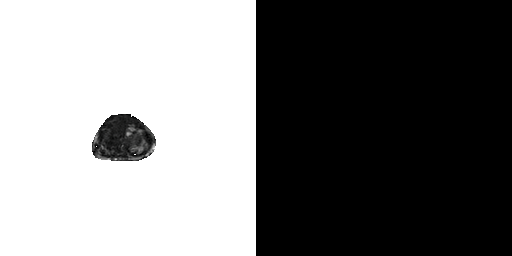

In [10]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    img = ToPILImage()(Denormalize()(sample["image"][index].clone()))
    msk = ToPILImage()(sample["mask"][index]).convert("RGB")

    return Image.fromarray(np.hstack((np.array(img), np.array(msk))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

## Dataset: Prost


Let's check the shapes of the input images and masks.

We could now visualize a normal and abnormal sample from the validation set.

## Prepare Model and Callbacks

Now, the config file is updated as we want. We can now start model training with it. Here we will be using `datamodule`, `model` and `callbacks` to train the model. Callbacks are self-contained objects, which contains non-essential logic. This way we could inject as many callbacks as possible such as ModelLoading, Timer, Metrics, Normalization and Visualization

In addition to the training, we would like to perform inference using OpenVINO. Therefore we will set the export configuration to openvino so that anomalib would export the trained model to the openvino format.

In [11]:
# Set the export-mode to OpenVINO to create the OpenVINO IR model.
config.optimization.export_mode = "openvino"

# Get the model and callbacks
model = get_model(config)
callbacks = get_callbacks(config)

/home/valentini/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


In [12]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/home/valentini/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/valentini/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/pytorch_lightning/callbacks/m

Training: 0it [00:00, ?it/s]

/home/valentini/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
/home/valentini/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/torch/onnx/_internal/jit_utils.py:306: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/valentini/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/torch/onnx/utils.py:689: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/valentini/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/torch/onnx/utils.py:1186: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/2023.0/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /home/valentini/Documents/Tesi/Conda/anomalib/results/padim/prost/new_dataset/run/weights/openvino/model.xml
[ SUCCESS ] BIN file: /home/valentini/Documents/Tesi/Conda/anomalib/results/padim/prost/new_dataset/run/weights/openvino/model.bin


## Validation

In [13]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model, datamodule=datamodule)

/home/valentini/miniconda3/envs/anomalib_env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9467669129371643     │
│       image_F1Score       │    0.8888888359069824     │
│        pixel_AUROC        │     0.983187198638916     │
│       pixel_F1Score       │    0.13529248535633087    │
└───────────────────────────┴───────────────────────────┘

## OpenVINO Inference
Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.

### Load a Test Image

Let's read an image from the test set and perform inference using OpenVINO inferencer.

/home/valentini/Documents/Tesi/Conda/anomalib/datasets/prost/new_dataset/test/tumor/17.png
17


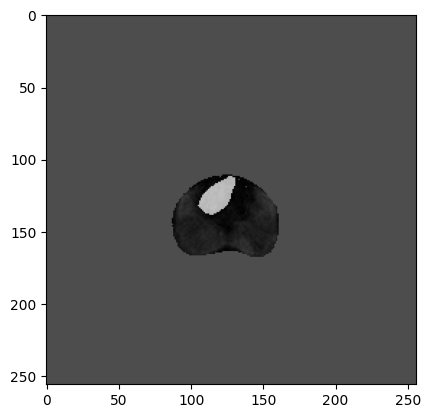

In [128]:
import random
random_int = random.randint(0, 40)

image_path = root_directory / "datasets/prost/new_dataset/test/tumor" / (str(random_int) + ".png")
#image = read_image(path="./datasets/prost/new_dataset/test/tumor" / + (str(random_int)+".png"))
image = read_image(path=image_path)
print(image_path)

mask_image_path = root_directory / "datasets/prost/new_dataset/ground_truth/tumor" / (str(random_int) + ".png")
mask_image = read_image(mask_image_path)
print(random_int)
plt.imshow(image)
plt.imshow(mask_image,alpha=0.7)

### Load the OpenVINO Model

By default, the output files are saved into `results` directory. Let's check where the OpenVINO model is stored.

In [129]:
output_path = Path(config["project"]["path"])
print(output_path)

results/padim/prost/new_dataset/run


In [130]:
openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
metadata = output_path / "weights" / "openvino" / "metadata.json"
print(openvino_model_path.exists(), metadata.exists())
metadata

True True


PosixPath('results/padim/prost/new_dataset/run/weights/openvino/metadata.json')

OpenVINO test 

In [131]:
from pathlib import Path
import json
import cv2

# Let's assume metadata_path is the path to your metadata file
metadata_path = metadata

# Load the metadata from the JSON file
with metadata_path.open() as f:
    metadata_file = json.load(f)
    image_threshold = metadata_file["image_threshold"]

# Update the "max" value
new_max_value = 18  # Replace this with your desired new value
metadata_file["max"] = new_max_value

image_threshold_value = 20
metadata_file["image_threshold"] = image_threshold_value 

pixel_threshold_value = 15
metadata_file["pixel_threshold"] = pixel_threshold_value 

# Write the updated metadata back to the JSON file
with metadata_path.open('w') as f:
    json.dump(metadata_file, f, indent=4)

inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)
predictions = inferencer.predict(image=image)


while ((predictions.pred_mask/255).sum()) < 100 or ((predictions.pred_mask/255).sum())>500: 
    # Let's assume metadata_path is the path to your metadata file
    metadata_path = metadata

    # Load the metadata from the JSON file
    with metadata_path.open() as f:
        metadata_file = json.load(f)
        image_threshold = metadata_file["pixel_threshold"]
        print("threshold")
        print(image_threshold)
    #metadata_file=metadata_file["image_threshold"]  

    print((predictions.pred_mask/255).sum())

    if (predictions.pred_mask/255).sum() > 500:
         image_threshold += 1
    else :
        image_threshold -= 1
    metadata_file["pixel_threshold"] = image_threshold 
    print(metadata_file["pixel_threshold"])

    # Write the updated metadata back to the JSON file
    with metadata_path.open('w') as f:
        print("True")
        json.dump(metadata_file, f, indent=4)

    inferencer = OpenVINOInferencer(
        path=openvino_model_path,  # Path to the OpenVINO IR model.
        metadata=metadata,  # Path to the metadata file.
        device="CPU",  # We would like to run it on an Intel CPU.
    )
    predictions = inferencer.predict(image=image)

print((predictions.pred_mask/255).sum())

114.0


In [132]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

### Perform Inference
Predicting an image using OpenVINO inferencer is as simple as calling `predict` method.

In [133]:
print(image.shape)

(256, 256, 3)


In [134]:
predictions = inferencer.predict(image=image)

where `predictions` contain any relevant information regarding the task type. For example, predictions for a segmentation model could contain image, anomaly maps, predicted scores, labels or masks.

### Visualizing Inference Results

In [135]:
print(predictions.pred_score, predictions.pred_label)

0.3410328980790973 False


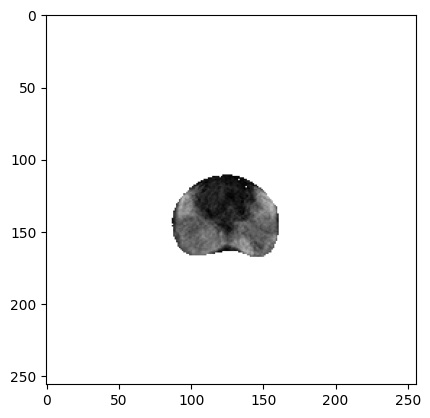

In [136]:
# Visualize the original image
plt.imshow(predictions.image)

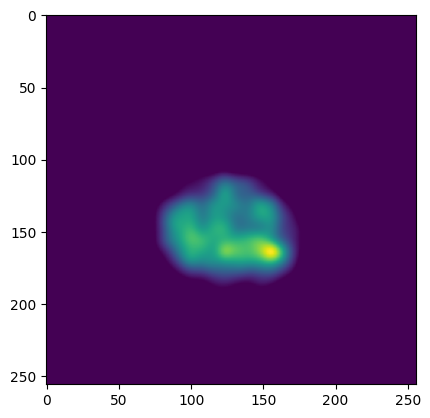

In [137]:
# Visualize the raw anomaly maps predicted by the model.
plt.imshow(predictions.anomaly_map)

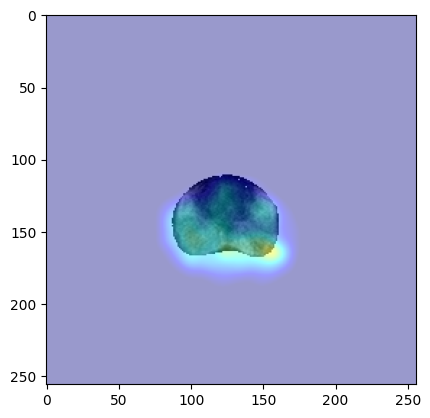

In [138]:
# Visualize the heatmaps, on which raw anomaly map is overlayed on the original image.
plt.imshow(predictions.heat_map)

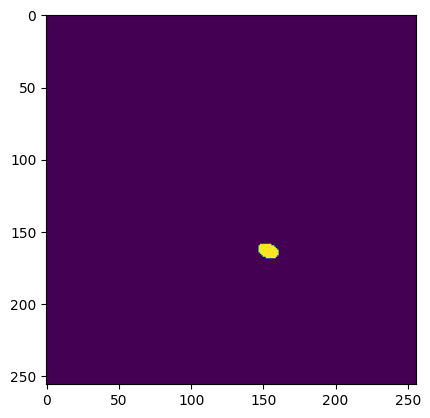

In [139]:
# Visualize the segmentation mask.
plt.imshow(predictions.pred_mask)

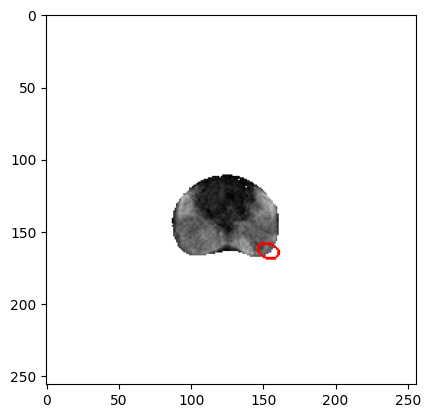

In [140]:
# Visualize the segmentation mask with the original image.
plt.imshow(predictions.segmentations)

In [141]:
import os
import pygame
import requests

pygame.init()
pygame.mixer.init()
doorbell_filename = './mixkit-airport-announcement-ding-1569.wav'


doorbell_sound = pygame.mixer.Sound(doorbell_filename)

doorbell_sound.play()
pygame.time.delay(int(doorbell_sound.get_length() * 1000) + 100)

pygame.quit()

This wraps the `getting_started` notebook. There are a lot more functionalities that could be explored in the library. Please refer to the [documentation](https://openvinotoolkit.github.io/anomalib/) for more details.